# **Case Study: Yelp Restaurant Recommendation System**

---------------
## **Context**
---------------

**Yelp** was founded in **2004** to help people find **great local businesses**. Today, the website and their mobile application publish crowd-sourced reviews about local businesses as well as certain metadata about them that can help in customer's **decision-making process**. Yelp uses automated software to recommend the **most helpful** and **reliable reviews** for the Yelp community from such a large and diverse dataset.

The Yelp dataset is a large collection of user reviews, business metadata, business check-ins, users' social network data, user tips for businesses across 10 cities spread across **4 countries**. The original dataset is very huge with ~ 11GB of data. In this case study, we will only use a subset of data due to the hardware limitations.

-----------------
## **Objective**
-----------------

In this case study, we will build three types of recommendation systems:
- **Knowledge/Rank Based recommendation system**
- **Similarity-Based Collaborative filtering**
- **Matrix Factorization Based Collaborative Filtering**


-----------------
## **Dataset**
-----------------

Out of many attributes available in the yelp_reviews data, we will only use the following four attributes:
- business_id
- business_name
- stars
- user_id

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this case study.

Let's start by mounting the Google drive on Colab.

In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the necessary libraries and overview of the dataset**

In [2]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Loading the data**

In [4]:
# Importing the dataset
yelp_review = pd.read_csv('/content/drive/MyDrive/yelp_reviews.csv', usecols = ['user_id', 'business_id', 'business_name', 'stars'])

# Dropping the "business_name" column
data = yelp_review.drop("business_name", axis = 1)

Let's check the **info** of the data.

In [5]:
# This method is used to get the info of the dataframe.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229907 entries, 0 to 229906
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  229907 non-null  object
 1   stars        229907 non-null  int64 
 2   user_id      229907 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


- There are **2,29,907 rows** and **3 columns** in the data.

## **Data Exploration**

Let's start with the data exploration.

**We will first see the first five records of the yelp_review data.**

In [6]:
# The head method is used to display the first five records of the dataset
data.head()

,business_id,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,5,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,5,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,4,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,5,uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,5,vYmM4KTsC8ZfQBg-j5MWkw


#### **Describe the distribution of ratings**

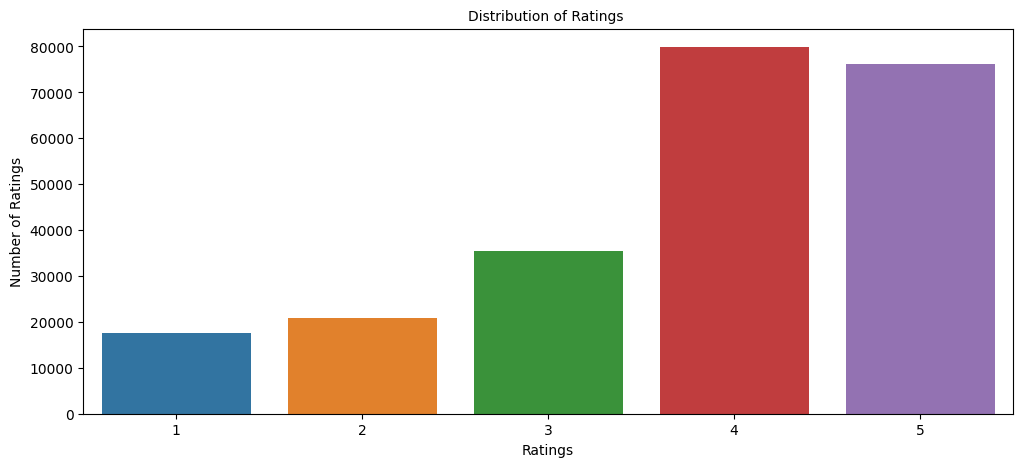

In [7]:
# Fix the figure size
plt.figure(figsize = (12, 5))

ax = sns.countplot(x = "stars", data = data)

plt.tick_params(labelsize = 10)

plt.title("Distribution of Ratings ", fontsize = 10)

# Set the xlabel of the plot
plt.xlabel("Ratings", fontsize = 10)

# Set the ylabel of the plot
plt.ylabel("Number of Ratings", fontsize = 10)

# Display the plot
plt.show()

**Observations:**

* The data seems to be **highly skewed** towards Rating **'4' and '5'**. Rating **'5'** is the second-highest in the count and nearly the same as the number of 4 rating count.

* We can see very few people are giving ratings **between 1 to 3**. It shows people tend to **not give a rating** for a restaurant that they **don't like**.

##### **What is the total number of unique users and unique restaurants**?

In [8]:
# Number of unique users
data['user_id'].nunique()

45981

In [9]:
# Number of unique restaurants
data['business_id'].nunique()

11537

**Observations:**
- There are **45,981 unique users** in the dataset.
- There are **11,537 unique restaurants** in the dataset.
- As per the number of unique users and restaurants, there is a **possibility of 45,981 * 11,537 = ~53 x 10^7 ratings** in the dataset. But **we only have 2,29,907 ratings**, i.e., not every user has rated every restaurant in the dataset. And we can build a recommendation system to recommend a restaurant to users which they have not visited.

#### **Is there any restaurant that has been visited more than once by the same user?**

In [10]:
# Find the sum of total ratings count by each user restaurant pair
data.groupby(['user_id', 'business_id']).count()['stars'].sum()

229907

- The **sum is equal to the total number of observations** which implies **there is only interaction between a pair of restaurants and a user**.

#### **Which restaurant is the most reviewed restaurant in the dataset?**

In [11]:
data['business_id'].value_counts()

hW0Ne_HTHEAgGF1rAdmR-g    844
VVeogjZya58oiTxK7qUjAQ    794
JokKtdXU7zXHcr20Lrk29A    731
ntN85eu27C04nwyPa8IHtw    679
EWMwV5V9BxNs_U6nNVMeqw    645
                         ... 
-NbEHP2GHFNb5PnmJnd4qQ      3
QICgwHWhXIbihfcMKtws8g      3
sAwxt4I4gTiL-08nyarJbg      3
huzUWI5YqkJEEIudo0YiDg      3
SeCVec3f91bEdosAILE4JA      3
Name: business_id, Length: 11537, dtype: int64

**Observations:**
- The **restaurant with business_id hW0Ne_HTHEAgGF1rAdmR-g  has been interacted by most users** which is **844** times.
- But still, there is a possibility of **45,981-844 = 45,137** more interactions as we have **45,981** unique users in our dataset. For those  **remaining users**, we can build a **recommendation system** to predict who is most likely to visit this restaurant.

Also, out of these **844 interactions**, we need to consider the distribution of ratings as well to check whether this restaurant is the **most liked or most disliked restaurant**.

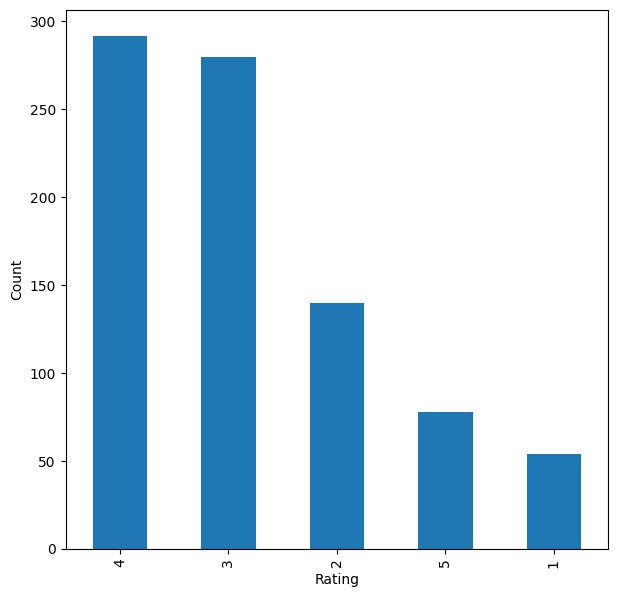

In [12]:
# Plotting distributions of ratings for 844 interactions with given business_id
plt.figure(figsize = (7, 7))

data[data['business_id'] == "hW0Ne_HTHEAgGF1rAdmR-g"]['stars'].value_counts().plot(kind = 'bar')

# Name the xlabel of the plot
plt.xlabel('Rating')

# Name the ylabel of the plot
plt.ylabel('Count')

# Display the plot
plt.show()

**Observations:**
- We can see that **this restaurant is not liked by many of the users**, as the count of ratings 3 and 4 is higher than the count of other ratings.
- There can be restaurants with very high interactions but the count of ratings **1 and 2** may be much higher than **4 or 5** which would imply that the restaurant is disliked by the majority of the users.

#### **Which user visited the most to any restaurant in the dataset?**

In [13]:
data['user_id'].value_counts()

fczQCSmaWF78toLEmb0Zsw    588
90a6z--_CUrl84aCzZyPsg    506
0CMz8YaO3f8xu4KqQgKb9Q    473
4ozupHULqGyO42s3zNUzOQ    442
joIzw_aUiNvBTuGoytrH7g    392
                         ... 
Oh9OOyDSGf4eNWGiNazh8g      1
Np9IEqnLmhRB2T5jumPTGw      1
g0-ejhzvo0ELNp04cUKWDg      1
M0lyA1jF0zrXZr5TXlioTQ      1
dDNfSFT0VApxPmURclX6_g      1
Name: user_id, Length: 45981, dtype: int64

**Observations:**
- The user with **user_id fczQCSmaWF78toLEmb0Zsw** has interacted with the most number of restaurants, i.e., **588** times.
- But still, there is a possibility of **11,537-588 =  10,949** more interactions as we have **11,537 unique restaurants** in our dataset. For those **10,949** remaining restaurants, we can build a recommendation system to predict which restaurants are most likely to be reviewed by this user.

## **Data Preparation**

As this dataset is still quite large and has 2,29,907 observations, it is not be computationally efficient to build a model using this. Moreover, there are many users who have only rated a few restaurants and also there are restaurants which are rated by very less users. Hence we can reduce the dataset by considering certain Logical assumption.

Here, we will be taking users who have given at least 100 rating, as we prefer to have some number of rating of a restaurant.

In [14]:
# Get the column containing the users
users = data.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [15]:
# We want our users to have at least 100 ratings to be considered
RATINGS_CUTOFF = 100

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = data.loc[ ~ data.user_id.isin(remove_users)]

**As we have now explored the data, let's start building the Recommendation systems**

## Model 1: **Building Rank-Based Recommendation System**

Rank-based recommendation system provides recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when **we get a new user into the system** and the machine is not able to recommend a restaurant to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use a rank-based recommendation system to recommend a restaurant to the new user.

To build the rank-based recommendation system, we take the **average** of all the ratings provided to each restaurant and then rank them based on their average rating.

In [16]:
# Calculating average ratings
average_rating = data.groupby('business_id').mean()['stars']

# Calculating the count of ratings
count_rating = data.groupby('business_id').count()['stars']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [17]:
# Let us see the first 5 records of the final_rating
final_rating.head()

,avg_rating,rating_count
business_id,,
--5jkZ3-nUPZxUvtcbr8Uw,4.545455,11
--BlvDO_RG2yElKu9XA1_g,4.162162,37
-0D_CYhlD2ILkmLR0pBmnA,4.000000,5
-0QBrNvhrPQCaeo7mTo0zQ,4.333333,3
-0bUDim5OGuv8R0Qqq6J4A,2.333333,6


Now, let's create a function to find the **top n restaurant** for a recommendation based on the average ratings of the restaurant. We can also add a **threshold for a minimum number of visits** for a restaurant to be considered for recommendation.

In [18]:
def top_n_restaurant(data, n, min_interaction = 100):

    # Finding restautants with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get restaurants to recommend.

#### **Recommending top 5 restaurant with 50 minimum interactions based on popularity.**

In [19]:
list(top_n_restaurant(final_rating, 5, 50))

['8HQ8clouLGgee99KkR4vXA',
 'CKjcewWeWvdJ7TzOQbZOIw',
 '97Z7j4vH0kfzL10AONi4uA',
 '_TekkyyFeX_8MBepPIxuTg',
 'L-uPZxooP_ziXCtRrWi8Pw']

Now, that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation System**.

## **Model 2: Collaborative Filtering Based Recommendation System**

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example -
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc.</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos.</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites.</li>
    <li><b>Reading</b> of articles by readers on various blogs.</li>
</ol>

#### Types of Collaborative Filtering

- Similarity/Neighborhood-based
 * User-User Similarity-Based  
 * Item-Item Similarity-based
- Model based

### **Building a baseline user-user similarity based recommendation system.**

- Below we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library.
- Please use the following code to `install the surprise` library. You only do it **once** while running the code for the first time.

**!pip install surprise**

In [20]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3096336 sha256=3cb82e9498967a7773341c6b8eebdb83995bd4cbcb83a3bff5dd86863accf1db
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [21]:
# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing ratings, data should be in structure - user; item; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's understand some basic terminologies we will be using here.**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating (here 3.5)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold (here 3.5) is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.

**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which the company would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

In [22]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Returns precision and recall at k metrics for each user."""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant. When n_rec_k is 0,
        # Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended. When n_rel is 0,
        # Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2*precision * recall) / (precision + recall), 3))

Below we are loading the **dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**.

In [23]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the dataset
data = Dataset.load_from_df(df_final[['user_id', 'business_id', 'stars']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

- Now we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.
- **KNNBasic** is an algorithm that is also **associated with the surprise package**, it is used to find the **desired similar items among a given set of items**.

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 is taken for the recommended and relevant ratings**.
- In the **present case precision and recall both need to be optimized as the service provider would like to minimize both the losses discussed** above. Hence, the correct performance measure is the **F_1 score**.

## Model 2: **Building User-User Collaborative Filtering Model**

In [24]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the train set, and predict ratings for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_user_user)

RMSE: 1.0409
Precision:  0.773
Recall:  0.417
F_1 score:  0.542


- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**.
- Intuition of Recall - We are getting a **recall of almost 0.42**, which means out of **all the relevant restaurants, 42% are recommended**.
- Intuition of Precision - We are getting a **precision of almost 0.773**, which means **out of all the recommended restaurants 77.3% are relevant**.
- Here **F_1 score** of the **baseline model is almost 0.542**. It indicates that **mostly recommended restaurants were relevant and relevant restaurants were recommended** to the user. We will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

Let's now **predict rating for a user with `userId = rLtl8ZkDX5vH5nAx9C3q5Q` and `businessId = 9yKzy9PApeiPPOUJEtnvkg`** as shown below.

In [25]:
# Predicting rating for a sample user with a visited restaurant
sim_user_user.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.77   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.7675091038953616, details={'actual_k': 16, 'was_impossible': False})

- The above output shows that **the actual rating for this user-item pair is 5 and the predicted rating is 3.77** by the **user-user-similarity-based baseline model**. This implies that the model is under-estimating the ratings.

Below is the function to find the **list of users who have not seen the restaurant with business id "9yKzy9PApeiPPOUJEtnvkg"**.

In [60]:
def n_users_not_interacted_with(n, data, business_id):
    users_interacted_with_product = set(data[data['business_id'] == business_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [61]:
n_users_not_interacted_with(5, df_final, '9yKzy9PApeiPPOUJEtnvkg')

['4UUIpbOTPmu43wuC2aSGkg',
 'w1LjSa5wMexRIQ-82LKWmQ',
 '7C-jyTrOX-iJ-MrSJuh-8A',
 'Mb0psF4WQF7gZSuZafVr-g',
 'SGXahHRReksq3m_Zk9V20w']

Below we are **predicting rating for the  `userId = 4UUIpbOTPmu43wuC2aSGkg` but for a restaurant which this user has not seen yet, i.e., `business_id = 9yKzy9PApeiPPOUJEtnvkg`**

In [63]:
# Predicting rating for a sample user with a restaurant that is not-visited by the user
sim_user_user.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.76   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.7589814527944565, details={'actual_k': 16, 'was_impossible': False})

### **Improving similarity-based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. The default value for k is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. The default value for min_k is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [27]:
# Setting up the parameters grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0158068275696142
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Now let's build the **final model by using tuned values of the hyperparameters** which we received by using **grid search cross-validation**.

In [28]:
# Using the optimal similarity measure for user-user-based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0060
Precision:  0.762
Recall:  0.413
F_1 score:  0.536


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model has reduced a bit as compared to the baseline model.**

Let's us now **predict rating for a user with `userId` = "rLtl8ZkDX5vH5nAx9C3q5Q", and business_id = "9yKzy9PApeiPPOUJEtnvkg" with the optimized model as shown below**.

In [29]:
sim_user_user_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.77   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.7675091038953616, details={'actual_k': 16, 'was_impossible': False})

Below we are predicting rating for the **`userId = "rLtl8ZkDX5vH5nAx9C3q5Q"`** but for a restaurant which this user has **not visited before**, i.e., `business_id = 9yKzy9PApeiPPOUJEtnvkg`, by using the **optimized model** as shown below -

In [64]:
sim_user_user_optimized.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.76   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.7589814527944565, details={'actual_k': 16, 'was_impossible': False})

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below we are finding the 5 most similar users to the first user in the list with internal id 0.

In [31]:
# Here 0 is the internal id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[18, 52, 79, 97, 103]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are -

- data: A **rating** dataset.
- user_id: A user id **for which we want the recommendations**.
- top_n: The **number of items we want to recommend**.
- algo: The algorithm we want to use **for predicting the ratings**.
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm.

In [32]:
# Let us see first 5 records of the df_final dataframe
df_final.head()

,business_id,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,5,rLtl8ZkDX5vH5nAx9C3q5Q
6,zp713qNhx8d9KCJJnrw1xA,5,wFweIWhv2fREZV_dYkz_1g
13,WGNIYMeXPyoWav1APUq7jA,4,Xm8HXE1JHqscXe5BKf0GFQ
18,b5cEoKR8iQliq-yT2_O0LQ,3,UsULgP4bKA8RMzs8dQzcsA
19,4JzzbSbK9wmlOBJZWYfuCg,4,nDBly08j5URmrHQ2JCbyiw


In [33]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended restaurant ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'business_id', values = 'stars')

    # Extracting those restaurant ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the restaurant ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    # Returing top n highest predicted rating restaurants for this user
    return recommendations[:top_n]

#### **Predicted top 5 business/product for userId = "rLtl8ZkDX5vH5nAx9C3q5Q" with similarity based recommendation system**

In [34]:
# Making top 5 recommendations for user_id "rLtl8ZkDX5vH5nAx9C3q5Q" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, sim_user_user)

In [35]:
# Building the dataframe for above recommendations with columns "business_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings'])

,business_id,predicted_ratings
0,--5jkZ3-nUPZxUvtcbr8Uw,5
1,-7XuLxfYwZ9x72mEKXdv0A,5
2,-A82xEVAjOYZtDdRQw1FQw,5
3,-CZ78c-H3tTxpP-uQ09CWw,5
4,-J0jhpG0rv4saq9OMh8gXw,5


### **Correcting the Ratings and Ranking the above products/ businesses**

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 by 3 people is less liked in comparison to a product rated 3 by 50 people**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [36]:
def ranking_products(recommendations, final_rating):
    # Sort the products based on ratings count
    ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

    # Merge with the recommended businesses to get predicted ratings
    ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings']), on = 'business_id', how = 'inner')

    # Rank the businesses based on corrected ratings
    ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

    # Sort the businesses based on corrected ratings
    ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)

    return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1 / np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [37]:
# Applying the ranking products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
0,--5jkZ3-nUPZxUvtcbr8Uw,11,5,4.698489
1,-J0jhpG0rv4saq9OMh8gXw,6,5,4.591752
2,-7XuLxfYwZ9x72mEKXdv0A,5,5,4.552786
3,-A82xEVAjOYZtDdRQw1FQw,5,5,4.552786
4,-CZ78c-H3tTxpP-uQ09CWw,3,5,4.422650


### Model 3: **Building Item Item Collaborative Filtering Model**

* Above we have seen **similarity-based collaborative filtering** where similarity has seen **between the users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between the items**.

In [38]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0218
Precision:  0.663
Recall:  0.344
F_1 score:  0.453


- The baseline model is giving an F_1 score of **about 45%**. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = rLtl8ZkDX5vH5nAx9C3q5Q` and `business_Id = 9yKzy9PApeiPPOUJEtnvkg`** as shown below. Here the user has already interacted or visited the restaurant with businessId "9yKzy9PApeiPPOUJEtnvkg".

In [39]:
# Predicting rating for a sample user with a visited restaurant
sim_item_item.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.48   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.475, details={'actual_k': 40, 'was_impossible': False})

Below we are **predicting rating for the `userId = 4UUIpbOTPmu43wuC2aSGkg` but for a restaurant which this user has not visited yet, i.e., `business_id = 9yKzy9PApeiPPOUJEtnvkg`**

In [65]:
# Predicting rating for a sample user with restaurant not visited by the user
sim_item_item.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.52   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.522856355785702, details={'actual_k': 40, 'was_impossible': False})

### **Improving similarity-based recommendation system by tuning its hyper-parameters**

Below we will be **tuning hyperparameters for the `KNNBasic` algorithms**.

In [41]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0086737725259012
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [42]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9986
Precision:  0.708
Recall:  0.375
F_1 score:  0.49


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is much better than the baseline model**. Also, there is a considerable fall in the RMSE value after tuning the hyperparameters. Hence the tuned model is doing better than the earlier one.

Let's us now predict **rating for an user with `userId = rLtl8ZkDX5vH5nAx9C3q5Q` and for `business_id = 9yKzy9PApeiPPOUJEtnvkg`** with the **optimized model** as shown below.

In [43]:
sim_item_item_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 4.90   {'actual_k': 30, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.896024464831805, details={'actual_k': 30, 'was_impossible': False})

- Here the optimized model is predicting a good rating (almost **4.90**) for the business whose actual rating is 5.

Below we are **predicting rating** for the **`userId = 4UUIpbOTPmu43wuC2aSGkg`** but for a restaurant which this user **has not visited before**, i.e., `business_id == 9yKzy9PApeiPPOUJEtnvkg`, by using the optimized model as shown below -

In [66]:
sim_item_item_optimized.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.57   {'actual_k': 30, 'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.5702603445087346, details={'actual_k': 30, 'was_impossible': False})

- For an unknown business the model is predicting a rating of **3.57**.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding 5 most similar items to the item with internal id 0 based on the `msd` distance metric

In [45]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[21, 27, 35, 51, 57]

#### **Predicted top 5 business/product for userId = "rLtl8ZkDX5vH5nAx9C3q5Q" with similarity based recommendation system.

In [46]:
# Making top 5 recommendations for user_id rLtl8ZkDX5vH5nAx9C3q5Q with similarity-based recommendation engine
recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, sim_item_item_optimized)

In [47]:
# Building the dataframe for above recommendations with columns "business_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings'])

,business_id,predicted_ratings
0,5Q49MxuWJgXS649i7i2Iow,4.416667
1,SmY_Xw31b2xyzsKbimQiHQ,4.346154
2,N6ff0yyo9Cv_7XPz-YDoow,4.308696
3,UmFnmIoLCRe1ywY0bzpRrQ,4.307692
4,p204PQg45gECcYwxCAK1wA,4.307692


In [48]:
# Applying the ranking_products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
1,5Q49MxuWJgXS649i7i2Iow,10,4.416667,4.100439
0,SmY_Xw31b2xyzsKbimQiHQ,15,4.346154,4.087955
2,N6ff0yyo9Cv_7XPz-YDoow,7,4.308696,3.930731
3,UmFnmIoLCRe1ywY0bzpRrQ,4,4.307692,3.807692
4,p204PQg45gECcYwxCAK1wA,3,4.307692,3.730342


* Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 4: Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item interaction matrix**. But SVD does not work when values are missing in the **user-item interaction matrix**.

### **Building a baseline matrix factorization recommendation system**

In [49]:
# Using SVD matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the train set
svd.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(svd)

RMSE: 0.9630
Precision:  0.77
Recall:  0.383
F_1 score:  0.512


- The baseline model with the algorithm is giving a nice F-1 score (almost **51%**). It indicates a good performance by the model.

- Let's now predict the rating for a user with **`userId = "rLtl8ZkDX5vH5nAx9C3q5Q`"** and **`business_id = "9yKzy9PApeiPPOUJEtnvkg"`** as shown below. Here the user has already rated..

In [50]:
# Making the prediction
svd.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 4.16   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.155179595069889, details={'was_impossible': False})

As we can see - **the actual rating** for this user-item pair is 5 and the predicted rating is also close to that. It seems like we have under-estimated the rating. We will try to fix this later by **tuning the hyperparameters** of the model using GridSearchCV.

Below we are predicting rating for the `userId = 4UUIpbOTPmu43wuC2aSGkg` but for a restaurant which this user has not seen before, i.e., `business_id = 9yKzy9PApeiPPOUJEtnvkg`, as shown below -

In [51]:
# Making prediction using the svd model
svd.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 4.09   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=4.09204353877637, details={'was_impossible': False})

We can see that the **estimated rating** for this **user-item pair** is ~4.10 based on this **matrix factorization based baseline model**.

### **Improving matrix factorization-based recommendation system by tuning its hyper-parameters.**

In SVD, rating is predicted as -

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iterations of the SVD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [52]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9582974352423079
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters as shown above.

Now we will **build the final model** by using **tuned values** of the hyperparameters which we received by using grid search cross-validation.

In [53]:
# Building the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 0.9507
Precision:  0.79
Recall:  0.402
F_1 score:  0.533


- We can see from above that the **tuned model** is showing a slightly better F_1 score than the baseline model, also the RMSE has gone down. Hence the tuned model is doing better than the earlier model.

Let's now predict a rating for a user with `userId = rLtl8ZkDX5vH5nAx9C3q5Q` and `BusinessId = 9yKzy9PApeiPPOUJEtnvkg` with the optimized model as shown below.

In [54]:
# Using svd_algo_optimized model to recommend for userId "rLtl8ZkDX5vH5nAx9C3q5Q" and business_Id 9yKzy9PApeiPPOUJEtnvkg
svd_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.91   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.9075441937737696, details={'was_impossible': False})

- The predicted rating is good here for a restaurant whose actual rating is **5**. The optimized model is giving a fairly good prediction.

In [67]:
# Using svd_optimized model to recommend for userId "rLtl8ZkDX5vH5nAx9C3q5Q" and businessId "zp713qNhx8d9KCJJnrw1xA" which the user has not visited
svd_optimized.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.53   {'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.5317237183975245, details={'was_impossible': False})

- For an unseen restaurant the rating given by the optimized model seems to be fine.

In [56]:
# Getting top 5 recommendations for user_id rLtl8ZkDX5vH5nAx9C3q5Q using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, svd_optimized)

In [57]:
# Ranking products based on above recommendations
ranking_products(svd_recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
1,X3icXUyW9vS4UXY6V_MR4w,79,4.764319,4.651811
0,GwSdGrvaXi4BdXNSWKn-EA,153,4.645138,4.564293
2,97Z7j4vH0kfzL10AONi4uA,78,4.637496,4.524268
3,XRBTHOXaJK_AJ2wy5mX_1A,26,4.622570,4.426454
4,4SviSw8uRF0ddj_HxUVnuA,10,4.623874,4.307647


### **Conclusion**

In this case study, we built recommendation systems using five different algorithms. They are as follows:
- rank-based using averages
- User-user-similarity-based collaborative filtering
- Item-item-similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering  

- We have seen how they are different from each other and what kind of data is needed to build each of these recommendation systems. We can further combine all the recommendation techniques we have seen.  
- To demonstrate **"user-user-similarity-based collaborative filtering","item-item-similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been introduced. For these algorithms **grid search cross-validation is applied to find the best working model**, and using that the **corresponding predictions are done**.

- **For performance evaluation** of these models **precision@k and recall@k** are introduced in this case study. Using these two metrics **F_1 score** is calculated for each working model.